In [1]:
import torch
from transformers import ViTForImageClassification
from src.model_helper import ModelHelper
from src import load_data as ld

In [2]:
TRAIN_MODEL = True

In [3]:
BATCH_SIZE = 16
NUM_CLASSES = 3 
FROZEN_LAYER = 1
LEARNING_RATE_BASE_MODEL = 2e-5
LEARNING_RATE_CLASSIFIER = 1e-4
WEIGHT_DECAY = 1e-4
BETAS=(0.9, 0.999)
AMSGRAD=True

In [4]:
dataset = ld.load_dataset('data')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Cuda isn't available!")

In [6]:
if not TRAIN_MODEL:
    mHelper = ModelHelper.load_model("models/ViT_20241110_1653-93.94.pth")
    model = mHelper.model

else:
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', 
                                                      num_labels=NUM_CLASSES, 
                                                      ignore_mismatched_sizes=True)
        
    for i, layer in enumerate(model.base_model.encoder.layer):
        if i < FROZEN_LAYER:
            for param in layer.parameters():
                param.requires_grad = False
    
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    model.to(device)
    
    
    print(model.config)
    
    for name, param in model.named_parameters():
        print(f"{name:60} | {'Trainable' if param.requires_grad else 'Frozen'} | Shape: {param.shape}")
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {total_params - trainable_params}")
    
    mHelper = ModelHelper(model, dataset, device, model_name="ViT", is_transformer=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.1"
}

vit.embeddings.cls_token                                     | Trainable | Shape: torch.Size([1, 1, 768])
vit.embeddings.position_embeddings                           | Trainable | Shape: torch.Size([1, 197, 768])
vit.embeddings.patch_embeddings.projection.weight

In [7]:
params = [
    {'params': model.base_model.parameters(), 'lr': LEARNING_RATE_BASE_MODEL},
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER},
]
optimizer = torch.optim.AdamW(params, weight_decay=WEIGHT_DECAY, betas=BETAS, amsgrad=AMSGRAD) 
criterion = torch.nn.CrossEntropyLoss()

In [8]:
mHelper.train_model(criterion, optimizer) if TRAIN_MODEL else mHelper.history

Device: cuda
Epoch [1/20]
----------


C:\Users\delia\anaconda3\envs\DS2\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train Loss: 0.3523 train Acc: 83.02%
val Loss: 0.2639 val Acc: 86.99%
--------------------------------------------------------------
Epoch [2/20]
----------
train Loss: 0.2172 train Acc: 90.25%
val Loss: 0.1778 val Acc: 92.09%
--------------------------------------------------------------
Epoch [3/20]
----------
train Loss: 0.1224 train Acc: 95.09%
val Loss: 0.3651 val Acc: 84.97%
--------------------------------------------------------------
Epoch [4/20]
----------
train Loss: 0.0572 train Acc: 97.91%
val Loss: 0.1214 val Acc: 95.61%
--------------------------------------------------------------
Epoch [5/20]
----------
train Loss: 0.0246 train Acc: 99.19%
val Loss: 0.1076 val Acc: 96.13%
--------------------------------------------------------------
Epoch [6/20]
----------
train Loss: 0.0205 train Acc: 99.38%
val Loss: 0.0955 val Acc: 96.05%
--------------------------------------------------------------
Epoch [7/20]
----------
train Loss: 0.0230 train Acc: 99.32%
val Loss: 0.1198 val 

In [ ]:
if TRAIN_MODEL:
    mHelper.evaluate_model()

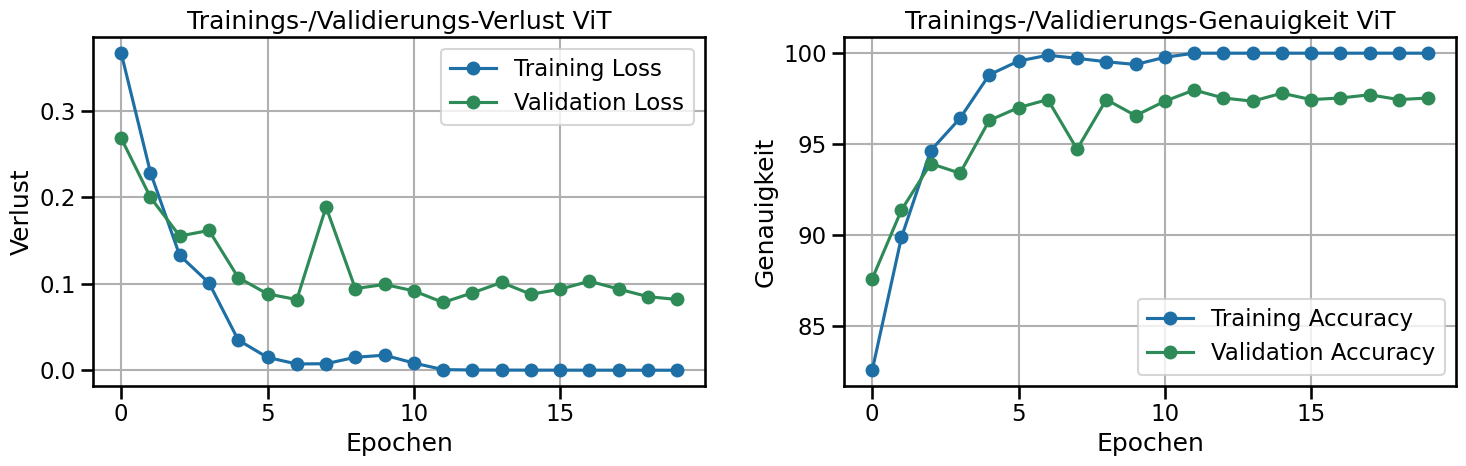

In [10]:
mHelper.plot_losses_and_accuracies()

In [11]:
if TRAIN_MODEL:
    mHelper.save_model()

ModelHelper saved to models/ViT_20241111_1628-97.63.pth


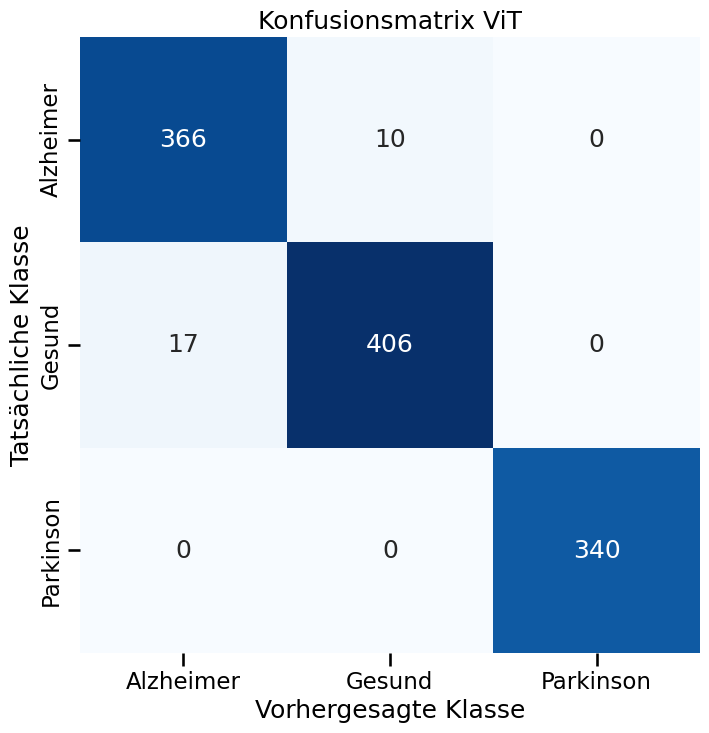

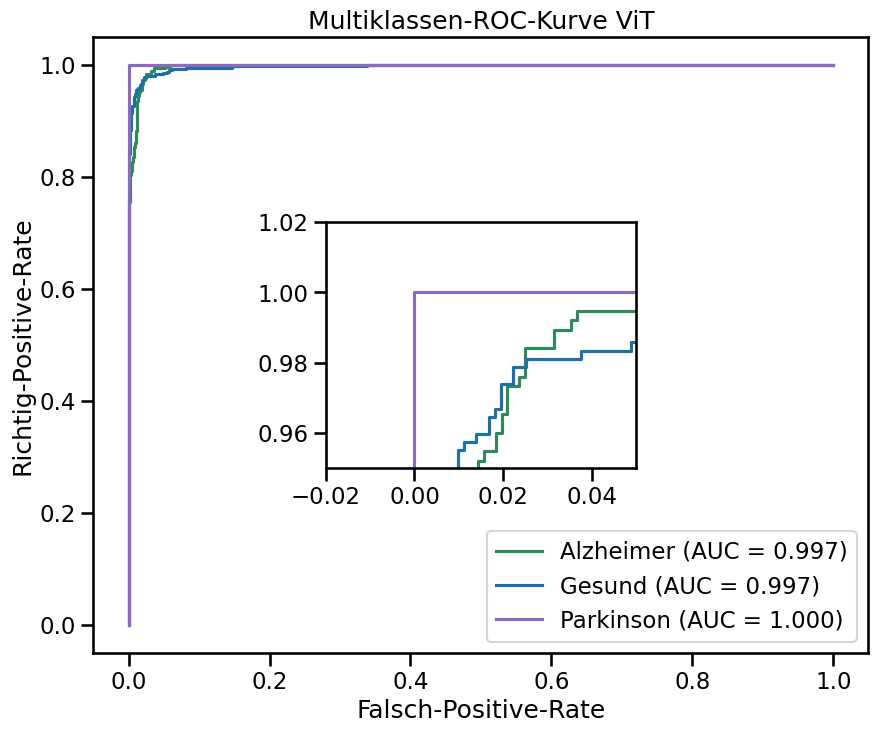

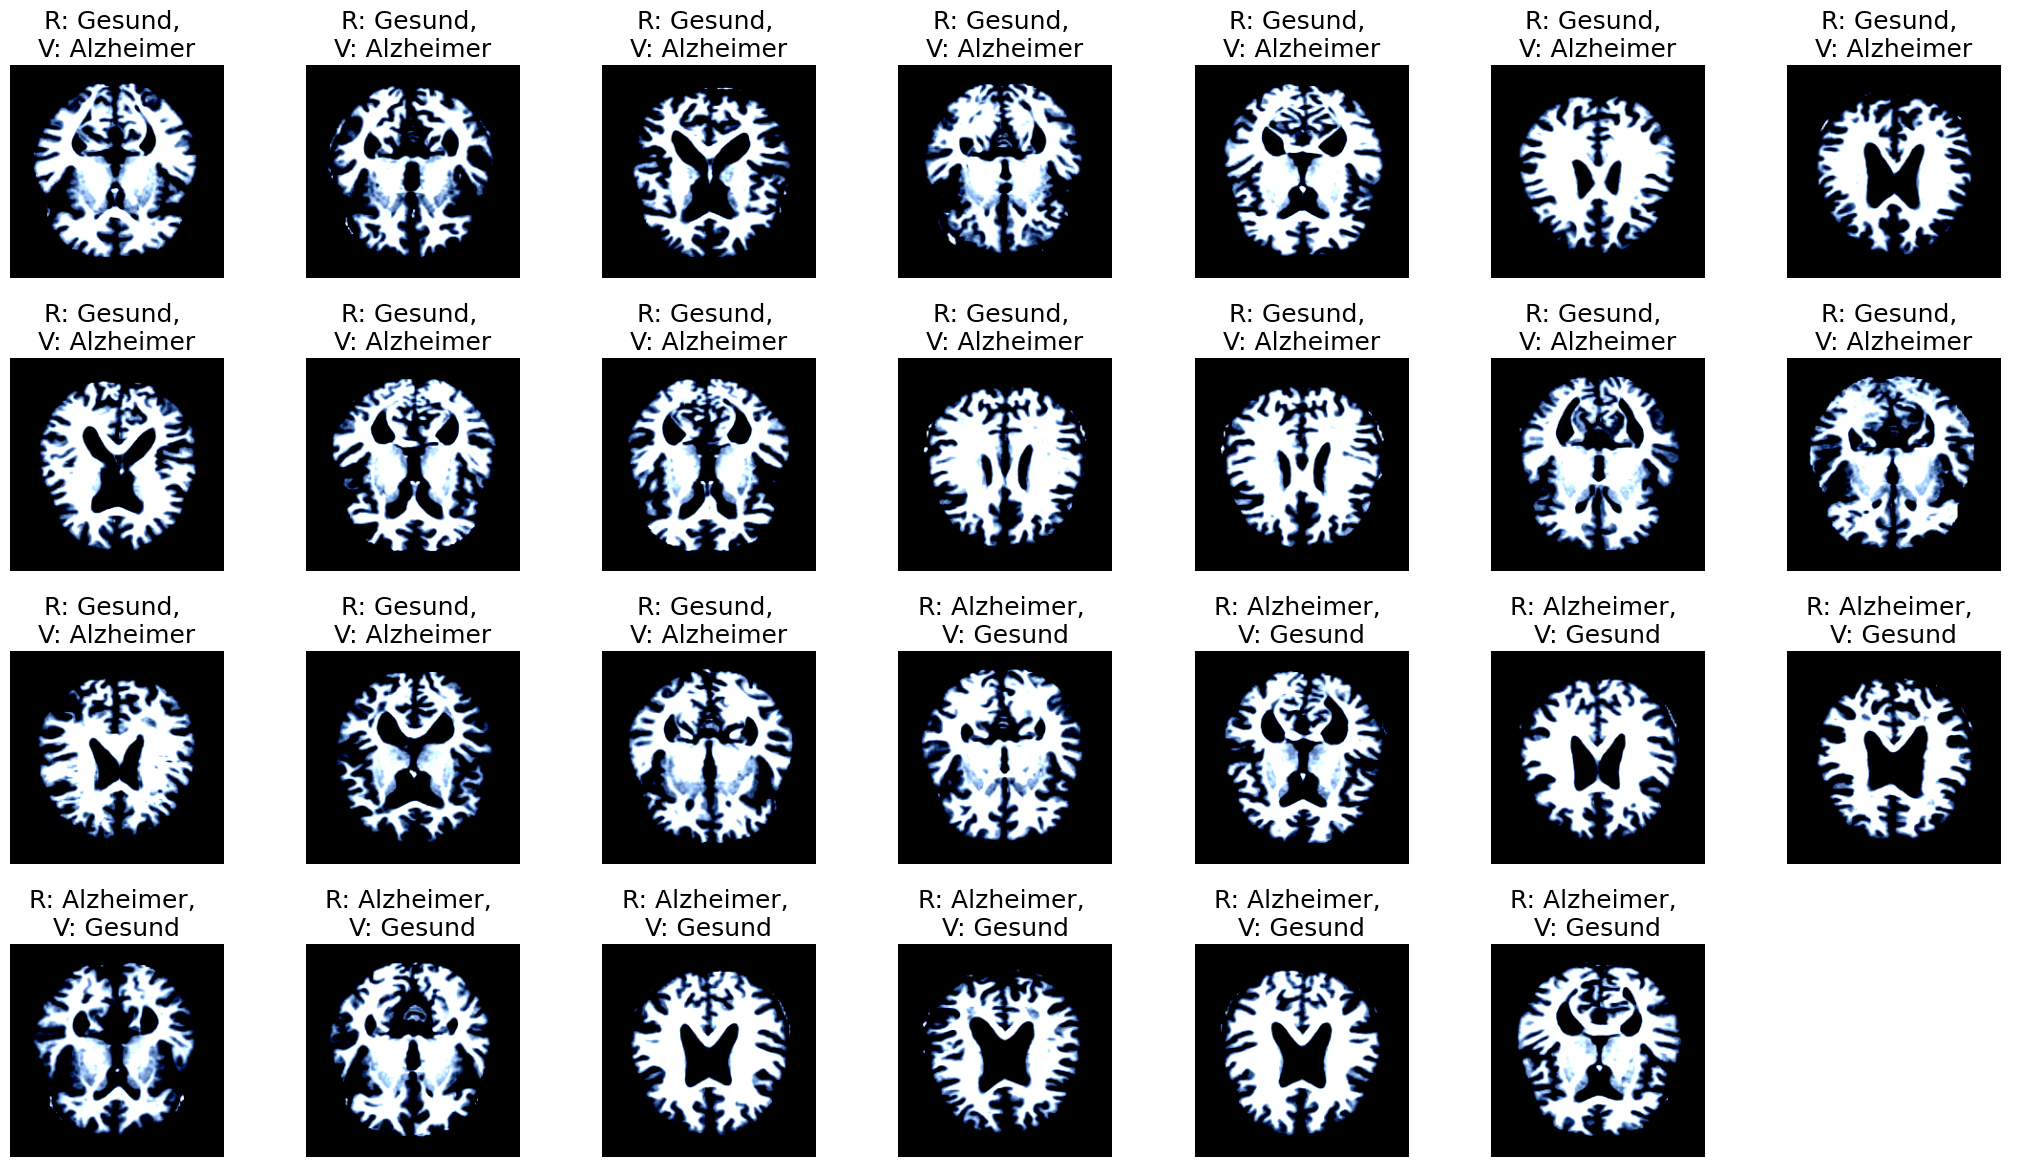

In [15]:
mHelper.plot_confusion_matrix()
mHelper.plot_multiclass_roc(NUM_CLASSES)
mHelper.plot_incorrect_images(max_columns=7)